In [1]:
#load libraries
library("tictoc")
library("forecast")

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [2]:
extraction_dir="catdef_extraction"
rdata_glob=paste(getwd(),"/",extraction_dir,"/*.RData",sep="")
print(paste("Data glob is ",rdata_glob))
rdata_files=Sys.glob(rdata_glob)

[1] "Data glob is  /home/jovyan/work/catdef_extraction/*.RData"


In [3]:
adatafile=rdata_files[1]
print(paste("To load ",adatafile))
load(adatafile)

[1] "To load  /home/jovyan/work/catdef_extraction/catdef.catdef_row.0.col.10.csv.RData"


In [4]:
ls()
#arima_fits=adata[1]
#print(arima_fits)

[1] "adatafile"      "arima_fits"     "extraction_dir" "rdata_files"   
[5] "rdata_glob"

In [5]:
arima_fits[1]

$fit
Series: cd_ts 
ARIMA(1,0,0)(2,1,0)[12] 

Coefficients:
         ar1     sar1     sar2
      0.8350  -0.5537  -0.3522
s.e.  0.0483   0.0841   0.0871

sigma^2 = 1327:  log likelihood = -663.58
AIC=1335.16   AICc=1335.47   BIC=1346.69


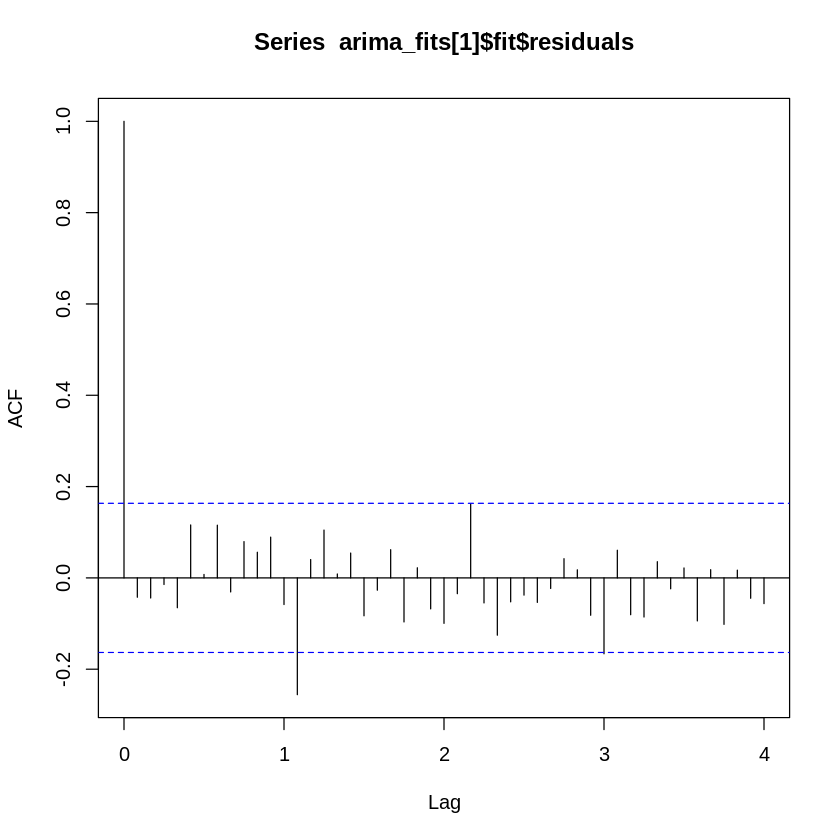

In [6]:
acf(arima_fits[1]$fit$residuals,lag.max=48)


	Ljung-Box test

data:  Residuals from ARIMA(1,0,0)(2,1,0)[12]
Q* = 27.904, df = 21, p-value = 0.1429

Model df: 3.   Total lags used: 24



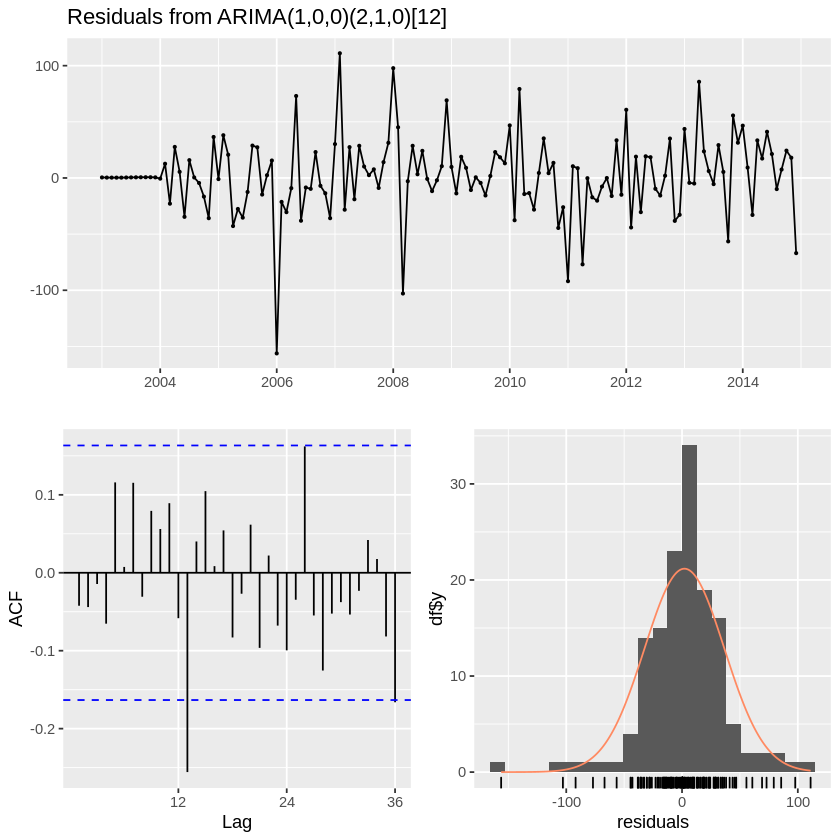

In [7]:
checkresiduals(arima_fits[1]$fit)

In [8]:
getPredicteds=function(base_csv,inc_month169=FALSE) {
    data_csv=base_csv
    pred_csv=paste(data_csv,".preds.csv",sep="")
    #Point.Forecast
    data_df=read.csv(file = data_csv,header=TRUE)
    pred_df=read.csv(file = pred_csv,header=TRUE)
    train_data=as.vector(data_df[1:144,1])
    combo_data=c(train_data,pred_df[,"Point.Forecast"])
    combo_df=data.frame(
        month=1:length(combo_data),
        data=combo_data
        )
    if(inc_month169) {
        return(combo_df)
    } else {
        num_rows=dim(combo_df)[1]
        combo_df=combo_df[1:(num_rows-1),]
        return(combo_df)
    }
}


getResidualDF=function(base_csv) {
    data_csv=base_csv
    pred_csv=paste(data_csv,".preds.csv",sep="")
    #Point.Forecast
    data_df=read.csv(file = data_csv,header=TRUE)
    pred_df=read.csv(file = pred_csv,header=TRUE)
    num_data=dim(data_df)[1]
    last_24_df=as.vector(data_df[(num_data-24+1):num_data,])
    first_24_fcst=as.vector(pred_df[1:24,"Point.Forecast"])
    actuals=last_24_df
    predicteds=first_24_fcst
    residuals_df=data.frame(
        actual=actuals,
        predicted=predicteds
    )
    return(residuals_df)
}
aresid_df=getResidualDF("catdef_extraction/catdef.catdef_row.0.col.10.csv")
computeMSEFromResidDF=function(resid_df) {
    actuals=as.vector(resid_df[,"actual"])
    predicteds=as.vector(resid_df[,"predicted"])
    errors=actuals-predicteds
    sq_errors=unlist(lapply(errors,function(x) { return(x*x)}))
    mean_sq_errors=mean(sq_errors)
    return(mean_sq_errors)
}
computeRMSE=function(resid_df) {
    mean_sq_errors=computeMSEFromResidDF(resid_df)
    rmse=sqrt(mean_sq_errors)
    return(rmse)
}


In [9]:
csv_glob=paste(getwd(),"/",extraction_dir,"/*.csv",sep="")
csv_files=Sys.glob(csv_glob)
#print(csv_files)
data_files=csv_files[grepl( ".preds", csv_files)==FALSE]
library("stringr")
extractRowFN=function(fn) {
    return(as.numeric(str_match(fn, "row\\.(\\d+)\\.")[2]))
}
extractColFN=function(fn) {
    return(as.numeric(str_match(fn, "col\\.(\\d+)\\.")[2]))
}


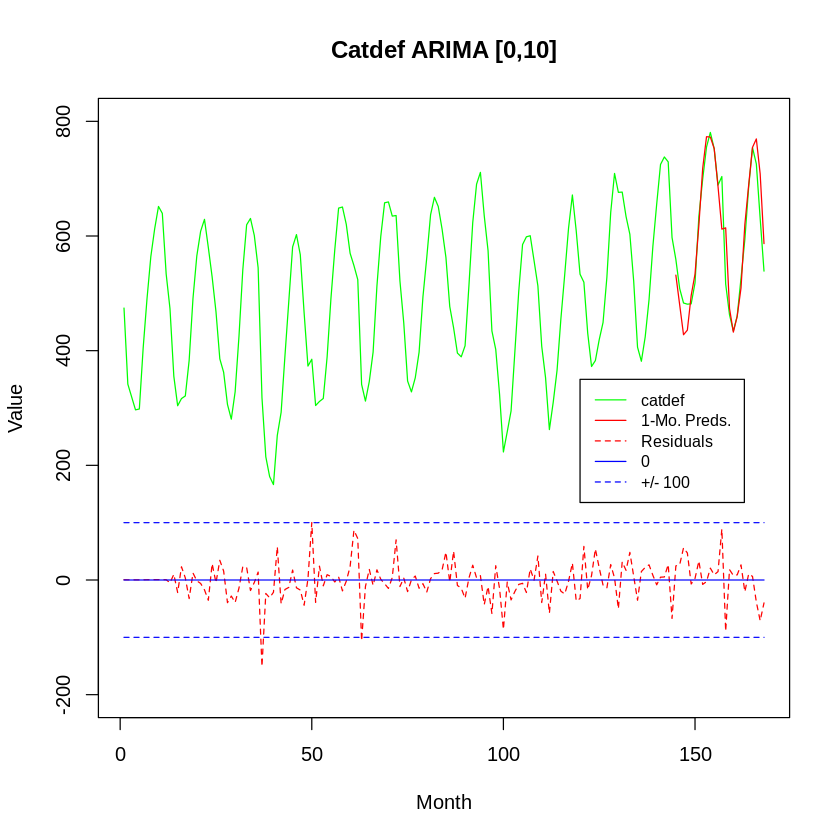

In [10]:
plotAboutAPoint=function(point_rd_file,extra_msg="") {
    load(point_rd_file)
    ncrd=nchar(point_rd_file)
    csv_to_use=substr(point_rd_file,1,ncrd-6)
    data_df_w_preds=getPredicteds(csv_to_use)
    fit_to_use=arima_fits[25]$fit
    show_df=data.frame(
        x=1:length(arima_fits[25]$fit$x),
        vals=fit_to_use$x,
        resids=fit_to_use$residuals,
        #fitted=arima_fits[25]$fit$fitted,
        fitted=data_df_w_preds$data
        )
    rd_row=extractRowFN(csv_to_use)
    rd_col=extractColFN(csv_to_use)
    plot_main=paste("Catdef ARIMA [",rd_row,",",rd_col,"]",sep="")
    if(nchar(extra_msg)>=2) {
        plot_main=paste(plot_main," ; ",extra_msg,sep="")
    }
    plot(show_df$x,show_df$vals,type="l",col="green",ylim=c(-200,800),
         xlab="Month",ylab="Value",main=plot_main  )
    legend(120, 350, legend=c("catdef", "1-Mo. Preds.","Residuals","0","+/- 100"), 
           col=c("green","red", "red","blue","blue"), lty=c(1,1,2,1,2), cex=0.8)
    lines(show_df$x,show_df$resids,type="l",col="red",lty=2)
    lines(show_df$x,rep(0,length(show_df$x)),type="l",col="blue")
    lines(show_df$x,rep(-100,length(show_df$x)),type="l",col="blue", lty=2)
    lines(show_df$x,rep(100,length(show_df$x)),type="l",col="blue", lty=2)
    lines(show_df$x[145:168],show_df$fitted[145:168],type="l",col="red")
}
plotAboutAPoint("catdef_extraction/catdef.catdef_row.0.col.10.csv.RData")

In [11]:
coef(arima_fits[25]$fit)

ar1       sma1      drift 
 0.8165762 -0.8405402  0.7824007

In [12]:
length(arima_fits[1]$fit$x)
length(arima_fits[25]$fit$x)
length(arima_fits[25]$fit$residuals)

[1] 144

[1] 168

[1] 168

In [13]:
names(arima_fits[25]$fit)

[1] "coef"      "sigma2"    "var.coef"  "mask"      "loglik"    "aic"      
 [7] "arma"      "residuals" "call"      "series"    "code"      "n.cond"   
[13] "nobs"      "model"     "xreg"      "bic"       "aicc"      "x"        
[19] "fitted"

In [14]:
length(arima_fits[25]$fit$fitted)

[1] 168

In [15]:
arima_fits[1]$fit

Series: cd_ts 
ARIMA(1,0,0)(2,1,0)[12] 

Coefficients:
         ar1     sar1     sar2
      0.8350  -0.5537  -0.3522
s.e.  0.0483   0.0841   0.0871

sigma^2 = 1327:  log likelihood = -663.58
AIC=1335.16   AICc=1335.47   BIC=1346.69

In [16]:
auto.arima(arima_fits[1]$fit$x)

Series: arima_fits[1]$fit$x 
ARIMA(1,0,0)(2,1,0)[12] 

Coefficients:
         ar1     sar1     sar2
      0.8350  -0.5537  -0.3522
s.e.  0.0483   0.0841   0.0871

sigma^2 = 1327:  log likelihood = -663.58
AIC=1335.16   AICc=1335.47   BIC=1346.69

In [17]:
auto.arima(diff(arima_fits[1]$fit$x,lag=12))

Series: diff(arima_fits[1]$fit$x, lag = 12) 
ARIMA(1,0,0)(2,0,0)[12] with zero mean 

Coefficients:
         ar1     sar1     sar2
      0.8350  -0.5537  -0.3522
s.e.  0.0483   0.0841   0.0871

sigma^2 = 1327:  log likelihood = -663.58
AIC=1335.16   AICc=1335.47   BIC=1346.69

In [18]:
rmse_df=data.frame(
    file=data_files,
    rmse=unlist(lapply(data_files,function(f) {return(computeRMSE(getResidualDF(f)))})),
    row=unlist(lapply(data_files,function(f) {return(extractRowFN(f))})),
    col=unlist(lapply(data_files,function(f) {return(extractColFN(f))}))
)

In [19]:
ordered_rmse_df=rmse_df[order(rmse_df['rmse']),]
ordered_rmse_df

Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”


,file,rmse,row,col
,<chr>,<dbl>,<dbl>,<dbl>
557,/home/jovyan/work/catdef_extraction/catdef.catdef_row.29.col.36.csv,9.136191,29,36
543,/home/jovyan/work/catdef_extraction/catdef.catdef_row.28.col.36.csv,9.440198,28,36
541,/home/jovyan/work/catdef_extraction/catdef.catdef_row.28.col.34.csv,9.553099,28,34
556,/home/jovyan/work/catdef_extraction/catdef.catdef_row.29.col.35.csv,10.006809,29,35
603,/home/jovyan/work/catdef_extraction/catdef.catdef_row.30.col.36.csv,10.079613,30,36
602,/home/jovyan/work/catdef_extraction/catdef.catdef_row.30.col.35.csv,10.168043,30,35
615,/home/jovyan/work/catdef_extraction/catdef.catdef_row.31.col.35.csv,10.584570,31,35
527,/home/jovyan/work/catdef_extraction/catdef.catdef_row.27.col.34.csv,10.875450,27,34
512,/home/jovyan/work/catdef_extraction/catdef.catdef_row.26.col.36.csv,10.924089,26,36


In [20]:
#make matrix of the data
num_rows_of_resid=dim(rmse_df)[1]
max_row=max(as.vector(rmse_df[,'row']))+1
max_col=max(as.vector(rmse_df[,'col']))+1
print(max_row)
print(max_col)
#matrix_data=rep(-1,max_row*max_col)
resid_matrix=matrix(-1,max_row,max_col)
for(row_idx in 1:num_rows_of_resid) {
    the_row=rmse_df[row_idx,'row']
    the_col=rmse_df[row_idx,'col']
    the_rmse=rmse_df[row_idx,'rmse']
    resid_matrix[the_row,the_col]=the_rmse
}


[1] 33
[1] 37


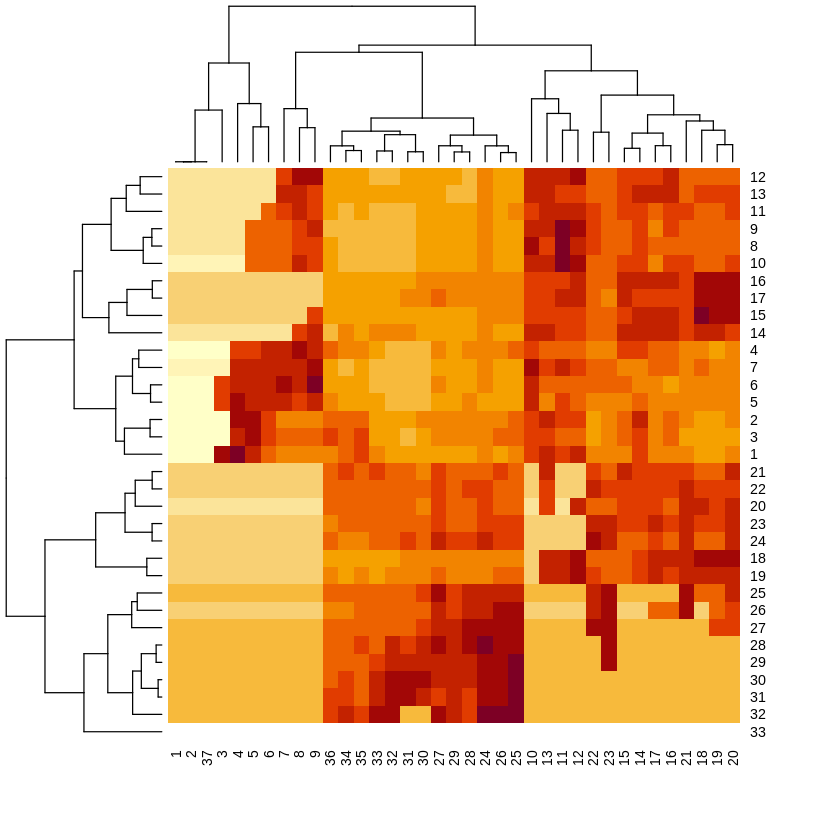

In [21]:
heatmap(resid_matrix)

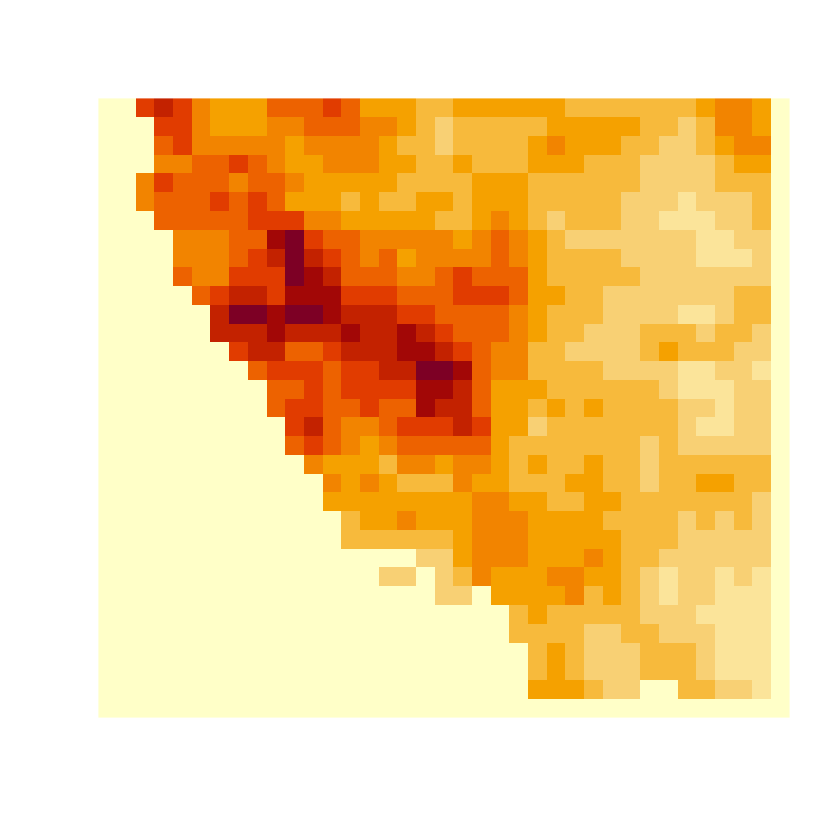

In [22]:
#https://stackoverflow.com/questions/31882079/r-image-plots-matrix-rotated
mat1 <- apply(resid_matrix, 2, rev)
#image(1:3, 1:3, t(mat1))
image(t(mat1), useRaster=TRUE, axes=FALSE)

In [23]:
best_csv=ordered_rmse_df[1,'file']
best_rmse=ordered_rmse_df[1,'rmse']
worst_csv=tail(ordered_rmse_df['file'],1)
worst_rmse=tail(ordered_rmse_df['rmse'],1)
print(paste("Best CSV ",best_csv))
print(paste("Worse CSV ",worst_csv))
best_rdata=paste(best_csv,".RData",sep="")
worst_rdata=paste(worst_csv,".RData",sep="")


[1] "Best CSV  /home/jovyan/work/catdef_extraction/catdef.catdef_row.29.col.36.csv"
[1] "Worse CSV  /home/jovyan/work/catdef_extraction/catdef.catdef_row.15.col.18.csv"


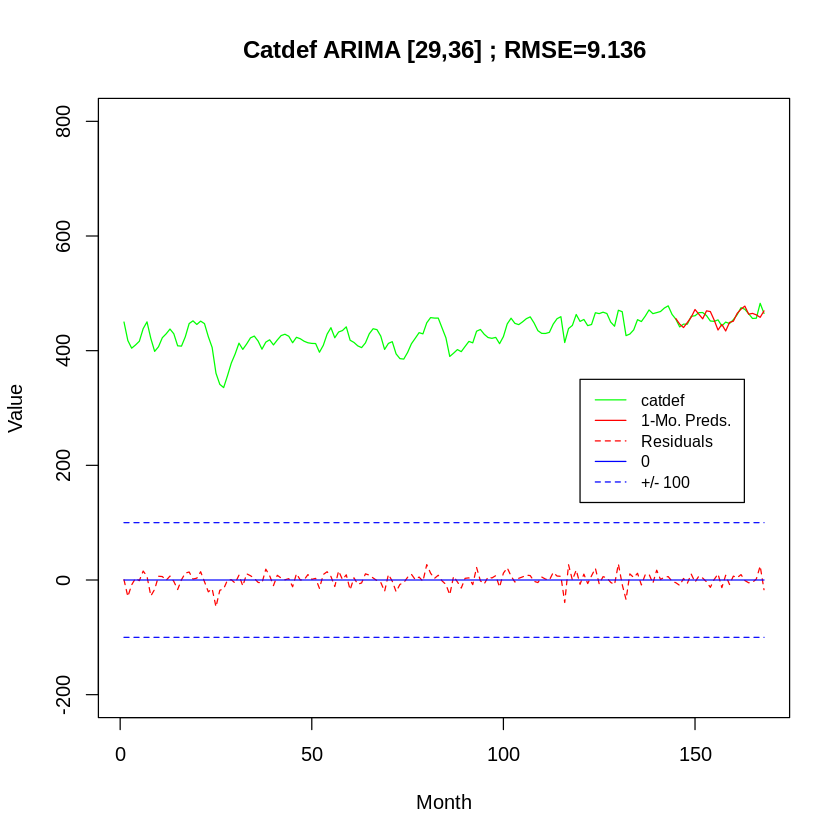

In [24]:
plotAboutAPoint(best_rdata,paste("RMSE=",round(best_rmse,3),sep=""))

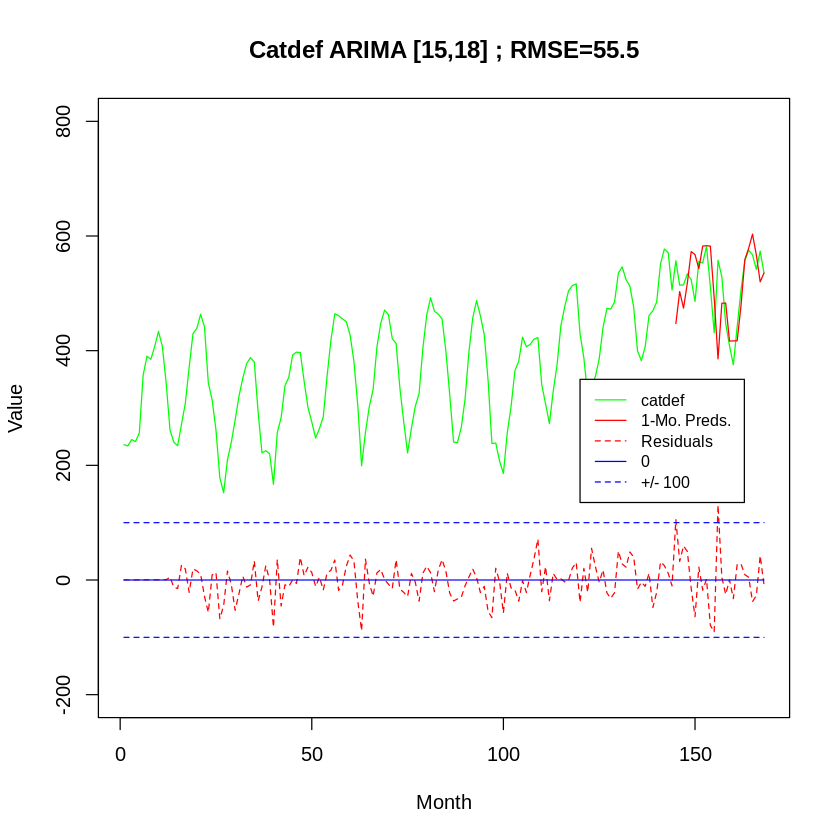

In [25]:
plotAboutAPoint(worst_rdata,paste("RMSE=",round(worst_rmse,3),sep=""))